# Unsupervised Sales Anomaly Detection
We are running the model to given test-data. Model will predict standard value of Sales Order based on following features:

- Wholesaler
- Retailer
- Line Count
- Line of HMS Product
- Sum Qty of Product
- Sum Qty of HMS 
- Value

Different between ***predicted HMS Value*** and ***actual value*** if beyond treshold wil be classified as anomaly

In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Load test dataset
Read test dataset and verify it shapes

In [42]:
orders = pd.read_csv("datasource/test_data/test_orders.csv")
prods = pd.read_csv("datasource/test_data/test_order_products.csv")
print("orders:",orders.shape)
print("prods:",prods.shape)

orders: (3000, 9)
prods: (27623, 10)


# Pre-processing

Check missing field

In [43]:
orders.isna().sum()

id                     0
wholesaler_id          0
retailer_id         1452
buyer_type             0
shipping_type          0
order_type             0
book_time              0
last_status            0
last_status_time       0
dtype: int64

In [44]:
prods.isna().sum()

id                    0
sku_id                0
brand               355
packaging             0
packaging_amount      0
amount                0
price                 0
book_time             0
last_status           0
last_status_time      0
dtype: int64

# Add features to Orders and Prods
Features' name should be explanatory 

In [45]:
orders["retailer_id"].fillna(0, inplace=True)
orders["trx_time"] = pd.to_datetime(orders["book_time"])
orders["trx_date"] = orders["trx_time"].dt.year*10000+orders["trx_time"].dt.month*100+orders["trx_time"].dt.day

# apply is_hms
prods["brand"].fillna("Other", inplace=True)
prods["is_hms"] = prods.apply(lambda x: 1 if str(x.brand).lower().find("sampoerna") > 0 else 0, axis=1)
prods["qty"] = prods["packaging_amount"] * prods["amount"]
prods["value"] = prods["price"] * prods["amount"]
prods["qty_hms"] = prods.apply(lambda x: x.qty if x.is_hms==1 else 0, axis=1)
prods["value_hms"] = prods.apply(lambda x: x.value if x.is_hms==1 else 0, axis=1)

# Aggregate line data to create more new features

In [46]:
prodSums = prods.groupby("id").agg({"is_hms":["count","sum"],"value":"sum","value_hms":"sum","qty":"sum","qty_hms":"sum"}).reset_index()
prodSums.columns = ["id","line_count","line_hms","value","value_hms","qty","qty_hms"]
prodSums.head(2)

,id,line_count,line_hms,value,value_hms,qty,qty_hms
0,3473338,3,3,359000,359000,15,15
1,3473442,3,0,653000,0,31,0


# Merge the aggregate

In [47]:
ordersum = orders = orders.merge(prodSums, how="left", on="id")
ordersum.head(2)

,id,wholesaler_id,retailer_id,buyer_type,shipping_type,order_type,book_time,last_status,last_status_time,trx_time,trx_date,line_count,line_hms,value,value_hms,qty,qty_hms
0,3585206,137074,114640.0,retailer,pick-up,app,6/9/2020 8:46,selesai,6/22/2020 22:12,2020-06-09 08:46:00,20200609,8,0,476600,0,10,0
1,3585223,172815,190897.0,retailer,pick-up,app,6/9/2020 8:47,pesanan-diterima,6/11/2020 15:05,2020-06-09 08:47:00,20200609,10,4,857500,278100,27,15


# Read model and its supporting

In [48]:
ai_mean = pd.read_csv("aimodel/unsupervised_sales_model/mean.csv")
ai_mean = ai_mean.reset_index().drop(columns=["Unnamed: 0","index"])
ai_mean.iloc[0]

wholesaler_id    137939.478185
retailer_id      217790.253025
line_hms              3.771338
qty_hms              36.002389
value_hms        854255.763217
Name: 0, dtype: float64

In [49]:
ai_std = pd.read_csv("aimodel/unsupervised_sales_model/std.csv")
ai_std = ai_std.reset_index().drop(columns=["Unnamed: 0","index"])
ai_std.iloc[0]

wholesaler_id    1.622166e+05
retailer_id      3.160594e+05
line_hms         2.760494e+00
qty_hms          9.590887e+01
value_hms        2.082334e+06
Name: 0, dtype: float64

In [50]:
model = tf.keras.models.load_model('aimodel/unsupervised_sales_model')

# Slice the record to be predicted and norrmalizing it

In [51]:
# get data to be test
hms = ordersum[ordersum["line_hms"]==1][ordersum["last_status"]!="konfirmasi-perubahan"]
hms_preds = hms[["wholesaler_id","retailer_id","line_hms","qty_hms","value_hms"]]
hms_norm = (hms_preds - ai_mean.iloc[0]) / ai_std.iloc[0]
hms_norm.shape

(552, 5)

# Predict and merge the result with initial data

In [52]:
import matplotlib.pyplot as plt

treshold = 3
results = model.predict(hms_norm.iloc[:,:4])
hms["value_hms_pred"] = (results * ai_std.iloc[0]["value_hms"]) + ai_mean.iloc[0]["value_hms"]
hms["diff"] = abs((hms["value_hms_pred"] - hms["value_hms"]) / hms["value_hms"])
hms["anomaly_label_pred"] = hms.apply(lambda x: 1 if x["diff"] > treshold else 0, axis=1)

In [53]:
# merge with order_sum
ds_pred = ordersum.merge(hms[["id","value_hms_pred","diff","anomaly_label_pred"]],how="left",on="id").fillna(0)
ds_pred.to_csv("dataresult/unsupervised_orders.csv")

# Check the prediction
We need to observe the data by features. Due to business needs, lets do by wholesaler

In [54]:
ds_pred.groupby("wholesaler_id").agg({"id":"count","anomaly_label_pred":"sum"}).sort_values("anomaly_label_pred", ascending=False).iloc[:5]

,id,anomaly_label_pred
wholesaler_id,,
140356,83,73.0
171889,14,9.0
158293,117,6.0
54022,36,6.0
175330,42,5.0


# Observe 1: 154557
Lets try observe wholesaler 154557

We can see from below chart, whenever anomaly found, the wholesaler is purchasing both HMS and Non-HMS Product. However, their purchase tend to be on small qty and amount compare to their standard, hence they are considered as ***anomaly***

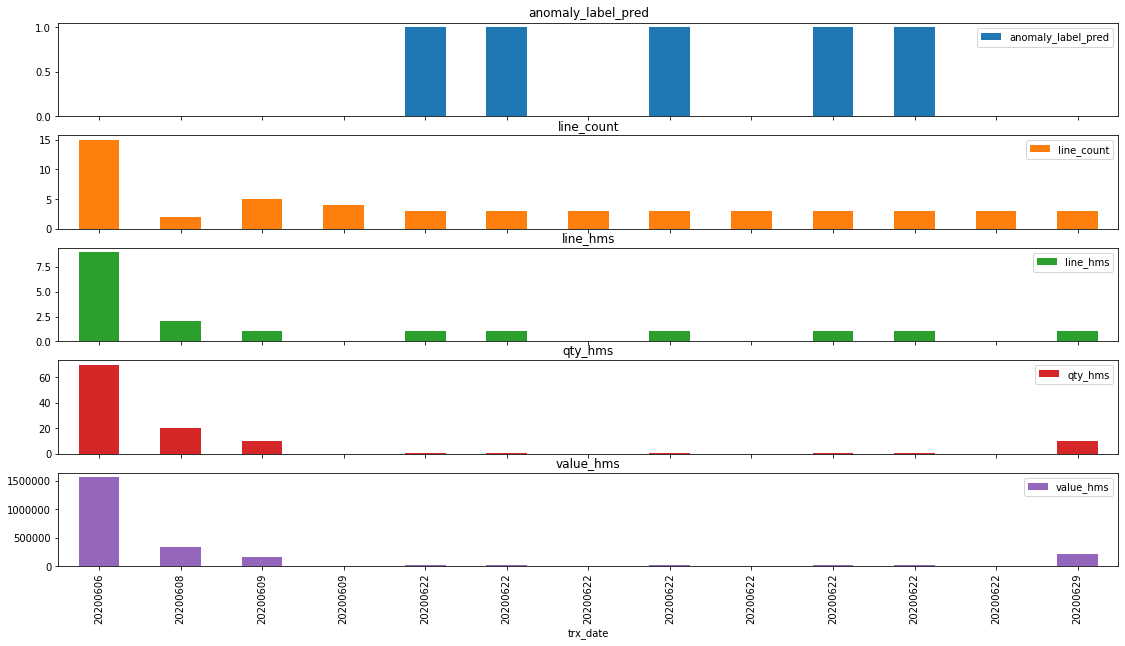

In [55]:
plots = ds_pred[ds_pred["wholesaler_id"]==154557][['anomaly_label_pred','trx_date',"line_count","line_hms","qty_hms","value_hms"]].sort_values("trx_date")
plot_features = plots.drop(columns=['trx_date'])
plot_features.index = plots["trx_date"]
_ = plot_features.plot(subplots=True, kind="bar", figsize=(19,10))

# Observe 2: 158293
Lets try observe wholesaler 158293

We can see from below chart, whenever anomaly found, the wholesaler is purchasing both HMS and Non-HMS Product. However, their purchase likely to be on small value despite sometime on high qty, this could be because the purchase in **bungkus** or other low product price, hence they are considered as anomaly

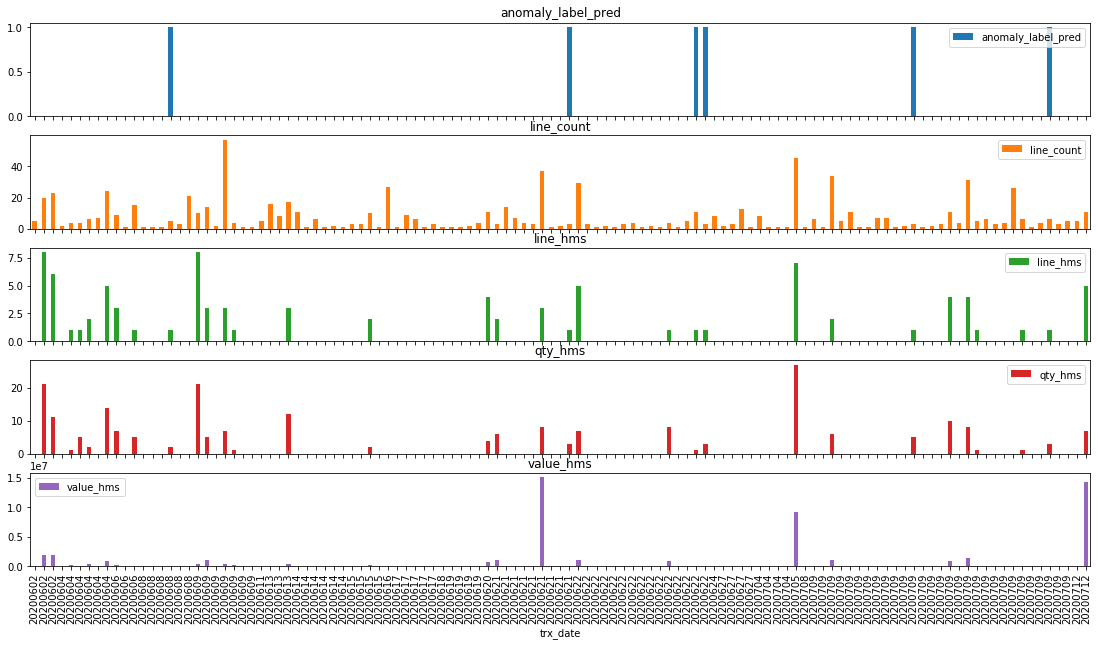

In [56]:
plots = ds_pred[ds_pred["wholesaler_id"]==158293][['anomaly_label_pred','trx_date',"line_count","line_hms","qty_hms","value_hms"]].sort_values("trx_date")
plot_features = plots.drop(columns=['trx_date'])
plot_features.index = plots["trx_date"]
_ = plot_features.plot(subplots=True, kind="bar", figsize=(19,10))